In [1]:
!pip install sentencepiece
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 46.3 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import konlpy
import pandas as pd

%matplotlib inline

# 1. 데이터 로드, 전처리, 분석

In [3]:
train_path = '/content/ratings_train.txt'
test_path = '/content/ratings_test.txt'

In [4]:
train_data = pd.read_table(train_path)
test_data = pd.read_table(test_path)

train = train_data['document']
test = test_data['document']

# 결측치 제거
train = train.dropna(axis=0)
test = test.dropna(axis=0)

# 앞뒤 공백 제거
train = train.apply(lambda x: x.strip())
test = test.apply(lambda x: x.strip())

# 중복 제거
train = train.drop_duplicates()
test = test.drop_duplicates()

# 한글과 공백을 제외하고 모두 제거
train = train.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test = test.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

# NaN 제거
train = train.str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train.replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')
test = test.str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
test.replace('', np.nan, inplace=True)
test = test.dropna(how = 'any')

train[:5]

,document
0,아 더빙 진짜 짜증나네요 목소리
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2,너무재밓었다그래서보는것을추천한다
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...


In [5]:
test[:5]

,document
0,굳 ㅋ
2,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3,지루하지는 않은데 완전 막장임 돈주고 보기에는
4,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
5,음악이 주가 된 최고의 음악영화


문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


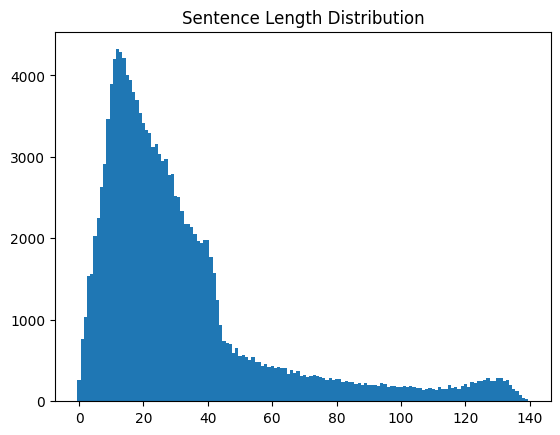

In [6]:
# 문장 길이 확인
min_len = 999
max_len = 0
sum_len = 0

for sen in train:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

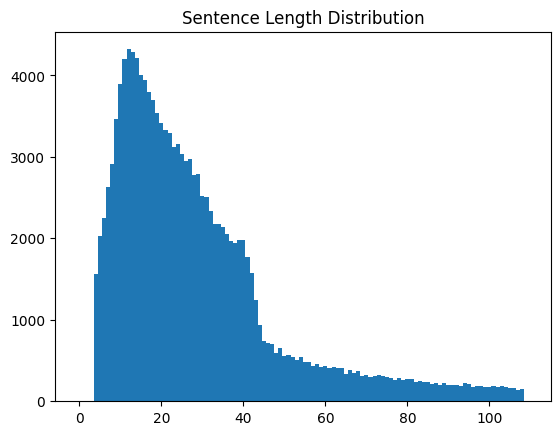

In [7]:
max_len = 110
min_len = 5

# [수정됨] train 길이 필터링 + 인덱스 유지
valid_train_idx = [i for i, s in enumerate(train) if (len(s) < max_len) and (len(s) >= min_len)]
train = [train.iloc[i] for i in valid_train_idx]
train_labels = train_data.iloc[valid_train_idx]['label'].values   # [수정됨]

# [수정됨] test 길이 필터링 + 인덱스 유지
valid_test_idx = [i for i, s in enumerate(test) if (len(s) < max_len) and (len(s) >= min_len)]
test = [test.iloc[i] for i in valid_test_idx]
test_labels = test_data.iloc[valid_test_idx]['label'].values      # [수정됨]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in train:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 2. SentencePiece 모델 학습

In [8]:
def tokenize(corpus, vocab_size=None):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [9]:
import sentencepiece as spm
import os
temp_file = './korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 379038 May 12 08:31 korean_spm.model
-rw-r--r-- 1 root root 148462 May 12 08:31 korean_spm.vocab


# 3. Tokenizer

In [10]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [11]:
import sentencepiece as spm

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

train_token = sp_tokenize(s, train)
test_token = sp_tokenize(s, test)

print(train_token[:5])

(array([[  57,  788,   25, ...,    0,    0,    0],
       [1510, 4521,  142, ...,    0,    0,    0],
       [  17,  375, 7794, ...,    0,    0,    0],
       ...,
       [ 125,  154,   40, ...,    0,    0,    0],
       [1739,  694, 4528, ...,    0,    0,    0],
       [ 247,    5, 3802, ...,    0,    0,    0]], dtype=int32), {'<unk>': 0, '<s>': 1, '</s>': 2, '▁': 3, '이': 4, '▁영화': 5, '의': 6, '가': 7, '도': 8, '는': 9, '을': 10, '에': 11, '고': 12, '다': 13, '은': 14, '지': 15, '한': 16, '▁너무': 17, '를': 18, '▁정말': 19, '만': 20, '▁이': 21, '게': 22, '로': 23, '나': 24, '▁진짜': 25, '영화': 26, '과': 27, '라': 28, '어': 29, '기': 30, '리': 31, '네': 32, '인': 33, '아': 34, '으로': 35, '하고': 36, '▁잘': 37, '▁안': 38, '서': 39, '요': 40, '▁왜': 41, '들': 42, '에서': 43, '와': 44, '▁그': 45, '▁점': 46, '▁이런': 47, '▁더': 48, '▁다': 49, '자': 50, '▁수': 51, '스': 52, '네요': 53, '해': 54, '거': 55, '하는': 56, '▁아': 57, '▁그냥': 58, '▁본': 59, '음': 60, '수': 61, '▁드라마': 62, '면': 63, '지만': 64, '▁보고': 65, '▁연기': 66, '니': 67, '시': 68, '▁내': 69, '▁평점

# 4. 네이버 영화리뷰 감정 분석 모델 재학습

In [13]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))  # vocab_size should match your vocabulary size
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(
    train_token[0], train_labels,
    validation_split=0.2,
    epochs=15,
    callbacks=[es, mc],
    batch_size=64
)

loaded_model = load_model('best_model.keras')
# Evaluate with the correctly sized test_labels
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_token[0], test_labels)[1]))

Epoch 1/15
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4979 - loss: 0.6934
Epoch 1: val_acc improved from -inf to 0.49595, saving model to best_model.keras
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - acc: 0.4979 - loss: 0.6934 - val_acc: 0.4960 - val_loss: 0.6932
Epoch 2/15
1696/1698 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5006 - loss: 0.6932
Epoch 2: val_acc did not improve from 0.49595
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - acc: 0.5006 - loss: 0.6932 - val_acc: 0.4960 - val_loss: 0.6932
Epoch 3/15
1697/1698 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5028 - loss: 0.6932
Epoch 3: val_acc improved from 0.49595 to 0.50405, saving model to best_model.keras
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - acc: 0.5028 - loss: 0.6932 - val_acc: 0.5040 - val_loss: 0.6931
Epoch 4/15
1694/1698 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.5005 - loss: 0.6932
Epoch 4: val_acc did not improve from 0.50405
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - acc: 0.5005 - loss: 0.6932 - val_ac

# 5. SentencePiece 모델 성능 개선

- accuracy가 50% 안팎인 걸 보면 학습이 제대로 안 되고 있는 것 같다.
- 뿐만 아니라 loss도 계속 그대로라서 코드를 수정할 필요가 있다.

# 6. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교

- okt

In [16]:
from konlpy.tag import Okt
okt = Okt()

def okt_tokenizer(texts):
    return [' '.join(okt.morphs(sentence)) for sentence in texts]

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 토큰화
train_tokens = okt_tokenizer(train)
test_tokens = okt_tokenizer(test)

# 정수 인코딩
tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_tokens)

train_seq = tokenizer.texts_to_sequences(train_tokens)
test_seq = tokenizer.texts_to_sequences(test_tokens)

# 패딩
train_pad = pad_sequences(train_seq, padding='post', maxlen=110)
test_pad = pad_sequences(test_seq, padding='post', maxlen=110)


In [18]:
# 길이 조건 맞는 index만 선택
train_filtered_idx = [i for i, s in enumerate(train_tokens) if (len(s.split()) >= 5 and len(s.split()) < 110)]
train_pad = train_pad[train_filtered_idx]
train_labels = train_data.iloc[train_filtered_idx]['label'].values

test_filtered_idx = [i for i, s in enumerate(test_tokens) if (len(s.split()) >= 5 and len(s.split()) < 110)]
test_pad = test_pad[test_filtered_idx]
test_labels = test_data.iloc[test_filtered_idx]['label'].values


In [19]:
model = Sequential()
model.add(Embedding(input_dim=8000, output_dim=100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_pad, train_labels,
    validation_data=(test_pad, test_labels),
    epochs=15, batch_size=64, callbacks=[es, mc])


Epoch 1/15
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.4999 - loss: 0.6934
Epoch 1: val_acc did not improve from 0.50405
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.4999 - loss: 0.6934 - val_acc: 0.4955 - val_loss: 0.6932
Epoch 2/15
1832/1836 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5015 - loss: 0.6932
Epoch 2: val_acc improved from 0.50405 to 0.50446, saving model to best_model.keras
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - acc: 0.5014 - loss: 0.6932 - val_acc: 0.5045 - val_loss: 0.6931
Epoch 3/15
1830/1836 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.4995 - loss: 0.6932
Epoch 3: val_acc did not improve from 0.50446
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.4995 - loss: 0.6932 - val_acc: 0.4955 - val_loss: 0.6933
Epoch 4/15
1834/1836 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.5036 - loss: 0.6931
Epoch 4: val_acc did not improve from 0.50446
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - acc: 0.5036 - loss: 0.6931 - val_acc: 0.5045 - val_loss: 0.6931
Ep

- okt도 spm 때와 마찬가지로 비슷한 수치를 보인다.
- 데이터 전처리부터 오류가 있는 것 같다.